# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime
import matplotlib.pyplot as plt 
from IPython.display import display

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


## Utils function
Function below will be used at multiple places and are so globalized

In [2]:
#print("Shape", portfolio.shape)

def drawSplitLine(lengthOfSplitline = 25):
    print("- " * lengthOfSplitline)


def getPandaTableInfo(table, tablename):
    rows, cols = table.shape
    print('"{0}" has {1} rows with {2} columns'.format(tablename, rows, cols ))
    display(table.head()) # https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs

def getValidationMetric(pred, correct):
    # Source: https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(correct, pred)
    
    # precision tp / (tp + fp)
    precision = precision_score(correct, pred)
    
    # recall: tp / (tp + fn)
    recall = recall_score(correct, pred)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(correct, pred)
    
    tn, fp, fn, tp = confusion_matrix(correct, pred).ravel()
    
    print('Accuracy:  %f' % accuracy)
    print('Precision: %f' % precision)
    print('Recall:    %f' % recall)
    print('F1 score:  %f' % f1)
    print('TN: {}, FP: {}, FN: {}, TP: {}'.format(tn, fp, fn, tp))

## Data - Analyse & Cleaning

### Portfolio - Data

In [3]:
getPandaTableInfo(portfolio, "Portfolio")

"Portfolio" has 10 rows with 6 columns


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


#### Cleaning
In this step I also execute the "dropna()" on the provided portfolio data provided by this project. 
But based on my output you can see that no entries will be removed, because no invalid datasets were given here.



In [4]:
print("portfolio uncleaned shape:        ", portfolio.shape)

drawSplitLine()
portfolio_cleaned = portfolio.dropna()

print("portfolio cleaned shape:          ", portfolio_cleaned.shape)

portfolio uncleaned shape:         (10, 6)
- - - - - - - - - - - - - - - - - - - - - - - - - 
portfolio cleaned shape:           (10, 6)


#### Analyse
Because the portfolio dataset is such small and mostly based on the referenced id from the transcript-dataset I'll make no detailed analyse using charts therefore. This will be added below.

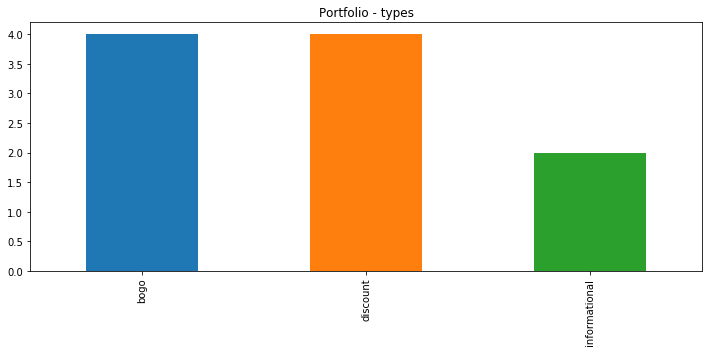

In [5]:
# Filtered out all profiles which has no valid age
fig, (ax11)  = plt.subplots(1,1, figsize=(10,5))  # 1 row, 2 columns

ax11.title.set_text("Portfolio - types")

portfolio_cleaned['offer_type'].value_counts(dropna=False).sort_index(ascending=True).plot(kind='bar', ax=ax11)

plt.tight_layout()  # Optional ... often improves the layout 

fig.savefig('./figures/portfolio-types.png')

### Profile - Data
In this chapter you will find some analysis and cleaning of the 

In [6]:
getPandaTableInfo(profile, "Profile")

"Profile" has 17000 rows with 5 columns


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


#### Cleaning

As you can see in the "profile"-table there are some people with obviously invalid or missing values
e.g.:
    - income of "NaN"
    - age "118"
    - gender "None"
As you can see in the output below the amount of those values in the specific column occures always 2175 times

In [7]:
print("NaN values in income")
print(profile['income'].isnull().value_counts(dropna=False))

drawSplitLine()
print("NaN values in gender")
print(profile['gender'].isnull().value_counts(dropna=False))

drawSplitLine()
print("118 values in age")
print((profile['age'] == 118).value_counts(dropna=False))

NaN values in income
False    14825
True      2175
Name: income, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - 
NaN values in gender
False    14825
True      2175
Name: gender, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - 
118 values in age
False    14825
True      2175
Name: age, dtype: int64


Remove invalid datasets from profile-dataset.
- Age 118 indicates that age-information was missing.
- Remove all entries with income or gender "NaN" or "None".
As named before, if one info was missing in this test-dataset all three were missing or three were given. There was no case were only some property was missing

In [8]:
profile_cleaned = profile[profile.age != 118] # Remove all ages 118 entries
profile_cleaned = profile_cleaned.dropna()    # Remove all rows with NaN or empty strings
print(profile_cleaned.count())

age                 14825
became_member_on    14825
gender              14825
id                  14825
income              14825
dtype: int64


#### Analyse
After removing the invalid profile data we have 14825 entries left. These values will now be visualized below to show their quantity ratio.
For comparsion reason I'll show the uncleaned quantity ratio on the left and the cleaned one on the right

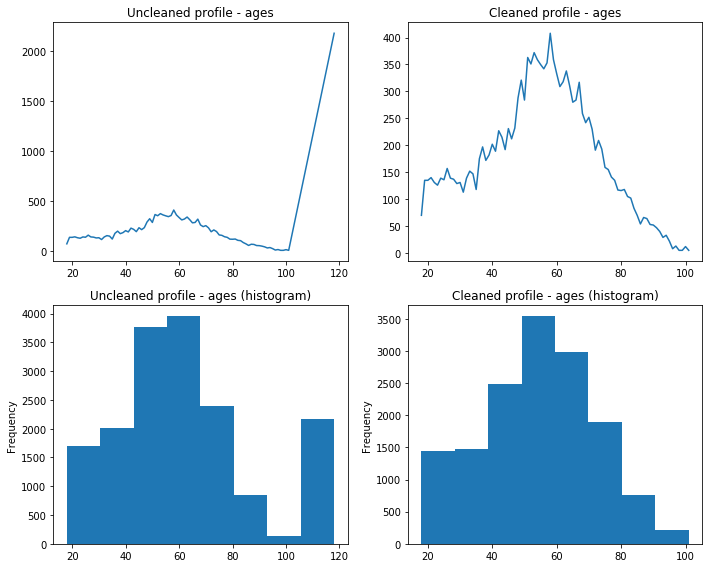

In [9]:
# Create subplots
fig, ((ax11,ax12), (ax21,ax22)) = plt.subplots(2,2, figsize=(10,8))  # 2 row, 2 columns

# Add titles
ax11.title.set_text("Uncleaned profile - ages")
ax12.title.set_text("Cleaned profile - ages")
ax21.title.set_text("Uncleaned profile - ages (histogram)")
ax22.title.set_text("Cleaned profile - ages (histogram)")

# Show plots
profile['age'].value_counts().sort_index(ascending=True).plot(kind='line', ax=ax11)
profile_cleaned['age'].value_counts().sort_index(ascending=True).plot(kind='line', ax=ax12)

profile["age"].plot.hist(bins=8, ax=ax21,)
profile_cleaned["age"].plot.hist(bins=8, ax=ax22)

# Potential layout improve: https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
plt.tight_layout()

fig.savefig('./figures/profiles-ages.png')

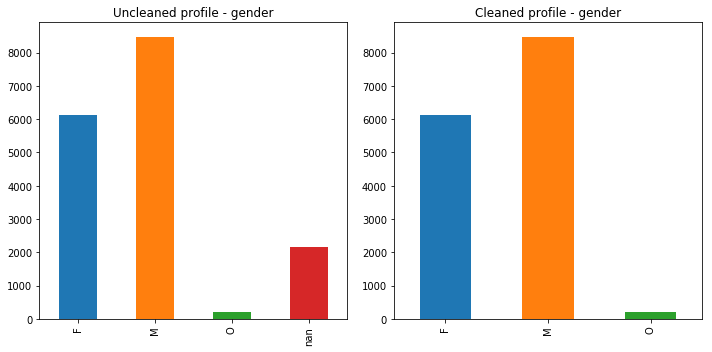

In [10]:
# Filtered out all profiles which has no valid age
fig, (ax11,ax12)  = plt.subplots(1,2, figsize=(10,5))  # 1 row, 2 columns

ax11.title.set_text("Uncleaned profile - gender")
ax12.title.set_text("Cleaned profile - gender")

profile['gender'].value_counts(dropna=False).sort_index(ascending=True).plot(kind='bar', ax=ax11)
profile_cleaned['gender'].value_counts(dropna=False).sort_index(ascending=True).plot(kind='bar', ax=ax12)

plt.tight_layout()  # Optional ... often improves the layout 

# print("Uncleaned")
# print(profile['gender'].value_counts(dropna=False))
# drawSplitLine()
# print("Cleaned")
# print(profile_cleaned['gender'].value_counts(dropna=False))

fig.savefig('./figures/profiles-genders.png')

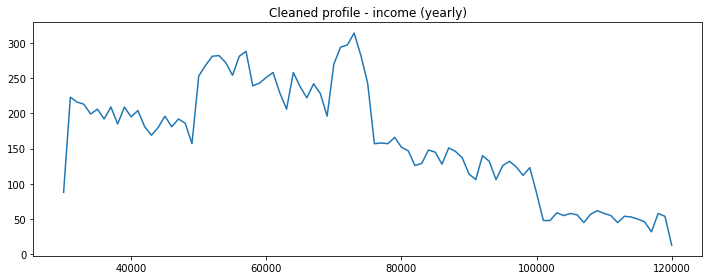

In [11]:
# Create subplots
fig, (ax11) = plt.subplots(1,1, figsize=(10,4))  # 2 row, 2 columns

# Add titles
ax11.title.set_text("Cleaned profile - income (yearly)")

# Show plots
profile_cleaned['income'].value_counts().sort_index(ascending=True).plot(kind='line', ax=ax11)

# Potential layout improve: https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
plt.tight_layout()

fig.savefig('./figures/profiles-income.png')

Because NaN values won't be show in the income-chart above (which I represent as a line chart) I've excluded the visualization of the uncleaned data data here:

### Transcript - data
In this chapter you will find some analysis and cleaning of the transcript-data (occured events/transactions)

In [12]:
getPandaTableInfo(transcript, "Transcript")

"Transcript" has 306534 rows with 4 columns


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


#### Cleaning
In this step I also execute the "dropna()" on the provided portfolio data provided by this project. 
But based on my output you can see that no entries will be removed, because no invalid datasets were given here.

In [13]:
print("transcript uncleaned shape:       ", transcript.shape)
drawSplitLine()

transcript_cleaned = transcript.dropna()
print("transcript_cleaned cleaned shape: ", transcript_cleaned.shape)

transcript uncleaned shape:        (306534, 4)
- - - - - - - - - - - - - - - - - - - - - - - - - 
transcript_cleaned cleaned shape:  (306534, 4)


#### Analyse
Below you find some analyse of quantity ratio of the given transcript data

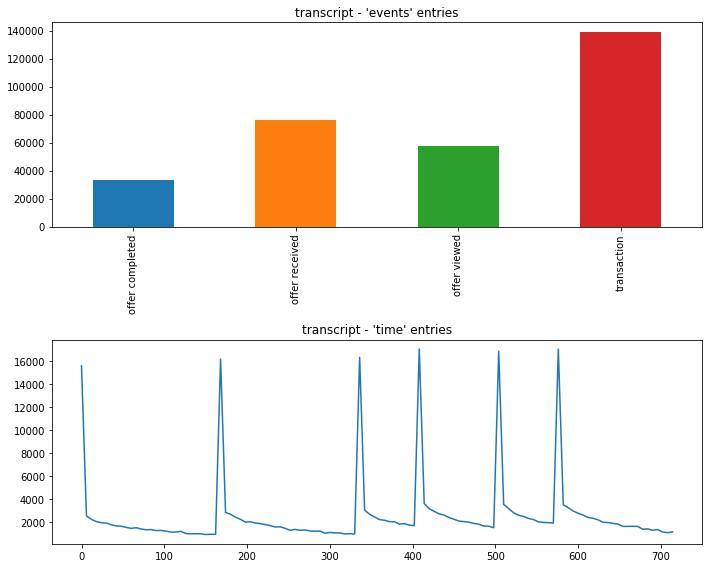

In [14]:
# Create subplots
fig, ((ax11), (ax12)) = plt.subplots(2, 1, figsize=(10,8))  # 2 row, 2 columns

# Add titles
ax11.title.set_text("transcript - 'events' entries")
ax12.title.set_text("transcript - 'time' entries")

# Show plots
transcript_cleaned['event'].value_counts().sort_index(ascending=True).plot(kind='bar', ax=ax11)
transcript_cleaned['time'].value_counts().sort_index(ascending=True).plot(kind='line', ax=ax12)

# Potential layout improve: https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
plt.tight_layout()

fig.savefig('./figures/transcripts-types-times.png')

<br/>

## Transform data

### Profile - data
For the profile data I'll do the following transformation:
- Replace gender with One-Hot-Encoding (column (flag-fields) for each gender)
- Calculcate how many days a profile is registered based on time difference between "became_member_on" and today date
- Convert floating point number of income to integer

In [15]:
def formatProfileData(cleaned_profile_data):
    transformed_profile = cleaned_profile_data.copy() # Get a copy
    
    # ----
    # Replace gender with One-Hot-Encoding (column (flag-fields) for each gender)
    transformed_profile['gender_male'] = np.where( transformed_profile['gender'] == 'M' , 1, 0) 
    transformed_profile['gender_female'] = np.where( transformed_profile['gender'] == 'F' , 1, 0) 
    transformed_profile['gender_other'] = np.where( transformed_profile['gender'] == 'O' , 1, 0) 
    
    # ----
    # Get days based on diff of current date to became_member_date
    today = datetime.datetime.today()

    transformed_profile['days_member'] = (today - pd.to_datetime(profile.became_member_on,format='%Y%m%d')).dt.days

    # ---- Convert format and removed unsed columns
    transformed_profile = transformed_profile.astype({ 'income': 'int' }) # Income type float -> int
    transformed_profile.drop(['became_member_on', 'gender'], axis=1, inplace=True) # Remove unused columns
    
    # Rename id column to "profile_id" which is easier to recognize when dataframe have been merged later
    transformed_profile.rename(columns={"id": "profile_id"}, inplace=True)

    return transformed_profile

profileTransformed = formatProfileData(profile_cleaned)
profileTransformed.head()


,age,profile_id,income,gender_male,gender_female,gender_other,days_member
1,55,0610b486422d4921ae7d2bf64640c50b,112000,0,1,0,1316
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000,0,1,0,1383
5,68,e2127556f4f64592b11af22de27a7932,70000,1,0,0,1031
8,65,389bc3fa690240e798340f5a15918d5c,53000,1,0,0,1107
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000,1,0,0,1197


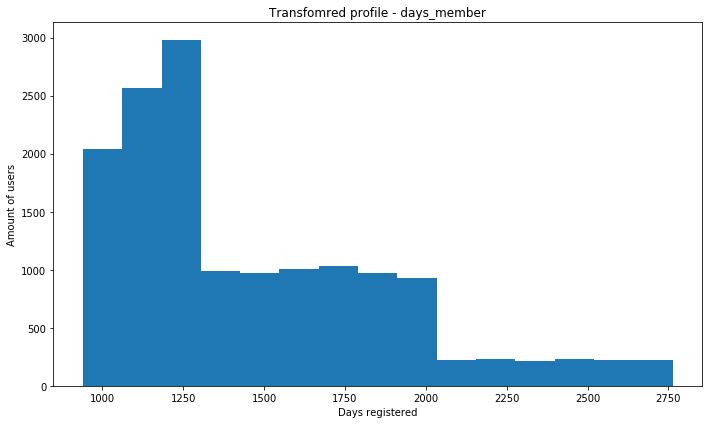

In [16]:
# Create subplots
fig, (ax11) = plt.subplots(1,1, figsize=(10,6))  # 2 row, 2 columns

# Add titles
ax11.title.set_text("Transfomred profile - days_member")

# Show plots
profileTransformed['days_member'].plot.hist(bins=15, ax=ax11)

ax11.set_xlabel("Days registered")
ax11.set_ylabel("Amount of users")

# Potential layout improve: https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
plt.tight_layout()

fig.savefig('./figures/profile-member_duration.png')

As expected you can see the most users have just registered at the end of the data collection and within the increasing amount of days the amount of users count is getting smaller.
This may be caused because user unregister from the app and also due to external factors like marketing for the app.
The amount of registered days should be a pretty good indicator for neural-network later on, because as mostly known a user
either decide to keep the app and use the offers made or is more likly to unregister when the offers are not liked by the user.

Because I use the difference of days between registration and today I'll ensure that I MinMaxScale this values before giving them as input into my neural network later

### Transcript - data
For the transcript data I'll do the following transformation:
- Break json object in "value" column into column (either amount or offer id)
  - The offerid key is mixed and is either written "offer_id" or "offer id" this will be unified
- 
- Calculcate how many days a profile is registered based on time difference between "became_member_on" and today date
- Convert floating point number of income to integer

In [17]:
# format transcript data
def formatTranscriptData(cleaned_transcript_data):
    transformed_transcripts = cleaned_transcript_data.copy() # Get a copy

    # Panda column of json into columns
    # https://stackoverflow.com/questions/49081097/slice-pandas-dataframe-json-column-into-columns
    transformed_transcripts = pd.concat([transformed_transcripts, transformed_transcripts['value'].apply(pd.Series)], axis=1)
    
    # For some reason offer_id was sometime written with _ or without _, 
    # the code below combine those to always use the offer id given
    transformed_transcripts['cleared_offer_id'] = np.where(transformed_transcripts['offer_id'].isnull(), transformed_transcripts['offer id'], transformed_transcripts['offer_id'])
    
    
    # One hot encode "event" column into separate columns with flag-field-values (1 or 0)
    transformed_transcripts['offer_received'] = np.where( transformed_transcripts['event'] == 'offer received' , 1, 0)
    transformed_transcripts['offer_viewed'] = np.where( transformed_transcripts['event'] == 'offer viewed' , 1, 0)
    transformed_transcripts['offer_completed'] = np.where( transformed_transcripts['event'] == 'offer completed' , 1, 0)
    transformed_transcripts['transaction'] = np.where( transformed_transcripts['event'] == 'transaction' , 1, 0)
    
    transformed_transcripts['time'] = transformed_transcripts['time'] / 60 # Convert time from min to hour. Same as duration from portfolio 
    
    # Remove columns which were combined in prev step
    transformed_transcripts.drop(['offer_id', 'offer id', 'value', 'event'], axis=1, inplace=True)
    
    # Rename temporary column for combination of "offer_id" and "offer id" column back to "offer_id"
    transformed_transcripts.rename(columns={
        "cleared_offer_id": "offer_id",
        "reward": "transcript_reward"
    }, inplace=True)
    
    
    return transformed_transcripts

transcriptTransformed = formatTranscriptData(transcript_cleaned)

transcriptTransformed.head()

,person,time,amount,transcript_reward,offer_id,offer_received,offer_viewed,offer_completed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0.0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0


### Portfolio - data
For the portfolio data I'll do the following transformation:
- Split the event-type into One-Hot-Encoding (separated columns with flag-values for the event-type)
  - The offerid key is mixed and is either written "offer_id" or "offer id" this will be unified
- 
- Calculcate how many days a profile is registered based on time difference between "became_member_on" and today date
- Convert floating point number of income to integer

In [18]:
def formatPortfolioData(cleaned_portfolio_data):
    transformed_portfolio = cleaned_portfolio_data.copy() # Get a copy
    
    # ----
    # Replace offer_type with One-Hot-Encoding (column (flag-fields) for each offer_type)
    transformed_portfolio['bogo'] = np.where( transformed_portfolio['offer_type'] == 'bogo' , 1, 0) 
    transformed_portfolio['informational'] = np.where( transformed_portfolio['offer_type'] == 'informational' , 1, 0) 
    transformed_portfolio['discount'] = np.where( transformed_portfolio['offer_type'] == 'discount' , 1, 0) 
    
    
    # Iterate through each row
    for i, r in transformed_portfolio.iterrows():
        # The code below could be reduced using a loop through ['web', 'email']... but it is easier to read like this
        # One hot encode the "channel"-list column into indvidual columns
        transformed_portfolio.loc[i, 'web'] = 1 if 'web' in transformed_portfolio.loc[i, 'channels'] else 0
        transformed_portfolio.loc[i, 'email'] = 1 if 'email' in transformed_portfolio.loc[i, 'channels'] else 0
        transformed_portfolio.loc[i, 'social'] = 1 if 'social' in transformed_portfolio.loc[i, 'channels'] else 0
        transformed_portfolio.loc[i, 'mobile'] = 1 if 'mobile' in transformed_portfolio.loc[i, 'channels'] else 0

    # One hot encoded channels-columns float -> int
    transformed_portfolio = transformed_portfolio.astype({ 'web': 'int', 
                                                          'email': 'int', 
                                                          'social': 'int', 
                                                          'mobile': 'int' 
                                                        }) 
    
    # Remove replaced/transformed columns which are not used anymore
    transformed_portfolio.drop(['offer_type', 'channels'], axis=1, inplace=True)
    
    # Rename id column to "profile_id" which is easier to recognize when dataframe have been merged later
    transformed_portfolio.rename(columns={
        "id": "portfolio_id",
        "reward": "portfolio_reward"
    }, inplace=True)
    
    return transformed_portfolio

portfolioTransformed = formatPortfolioData(portfolio_cleaned)
portfolioTransformed.head()

,difficulty,duration,portfolio_id,portfolio_reward,bogo,informational,discount,web,email,social,mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,0,1,1,1,0,0


<br>

## Data merging
In this chapter I'll start merging the datasets based on the foreign-keys (ids) and will visualize the outcomes ones more)




In [19]:
merged = pd.merge(transcriptTransformed, profileTransformed, left_on='person' , right_on='profile_id', how='left' )
merged = pd.merge(merged, portfolioTransformed, left_on='offer_id' , right_on='portfolio_id', how='left')

# Filter out all transcripts which referenced to a filtered profile-information (invalid age etc)
# These entries can be found when "age" is nan after the merge
merged = merged[merged['age'].notnull()]

merged.head()

,person,time,amount,transcript_reward,offer_id,offer_received,offer_viewed,offer_completed,transaction,age,...,duration,portfolio_id,portfolio_reward,bogo,informational,discount,web,email,social,mobile
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75.0,...,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,68.0,...,7.0,2906b810c7d4411798c6938adc9daaa5,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
5,389bc3fa690240e798340f5a15918d5c,0.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,65.0,...,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,1,0,0,0,58.0,...,4.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,61.0,...,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


### Analyse
After merging all entries from the given datasets to a single huge dataset I'll show some more graphs/charts below to visualize quantity ratio.

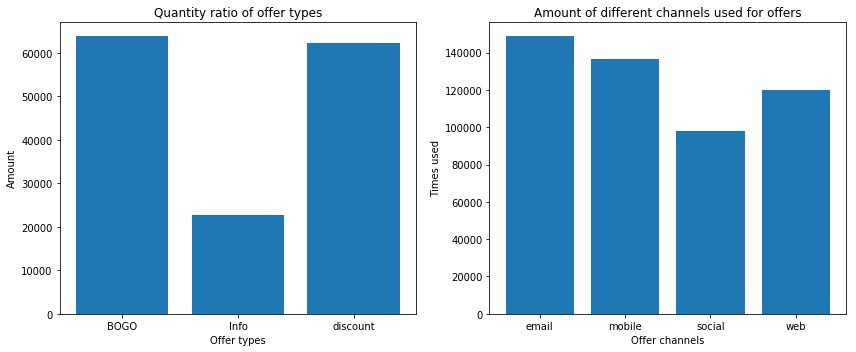

In [20]:
# Store types of offers set within transcripts
total_bogos = merged['bogo'].sum()
total_infos = merged['informational'].sum()
total_discount = merged['discount'].sum()

offer_type_x = ['BOGO', 'Info', 'discount']
offer_type_y = [total_bogos, total_infos, total_discount] 

# --

total_web = merged['web'].sum()
total_email = merged['email'].sum()
total_social = merged['social'].sum()
total_mobile = merged['mobile'].sum()


offer_channels_x = ['web', 'email', 'social', 'mobile']
offer_channels_y = [total_web, total_email, total_social, total_mobile]



# Create subplots
fig, (ax11, ax12) = plt.subplots(1,2, figsize=(12,5))  # 1 row, 2 columns


ax11.bar(offer_type_x, offer_type_y)
ax11.title.set_text("Quantity ratio of offer types")
ax11.set_xlabel("Offer types")
ax11.set_ylabel("Amount")

ax12.bar(offer_channels_x, offer_channels_y)
ax12.title.set_text("Amount of different channels used for offers")
ax12.set_xlabel("Offer channels")
ax12.set_ylabel("Times used")


# Potential layout improve: https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
plt.tight_layout()

fig.savefig('./figures/quantity_ratio_sent_offers.png')

In [21]:
receivedOffers = merged[merged['offer_received'] == 1]
viewedOffers = merged[merged['offer_viewed'] == 1]
completedOffers = merged[merged['offer_completed'] == 1]
transactions = merged[merged['transaction'] == 1]

receivedOffers_count = receivedOffers.shape[0]
viewedOffers_count = viewedOffers.shape[0]
completedOffers_count = completedOffers.shape[0]
transactions_count = transactions.shape[0]

viewedOffersPercent =  viewedOffers_count / receivedOffers_count * 100
completedffersPercent =  completedOffers_count / receivedOffers_count * 100

print('receivedOffers:  {0}'.format(receivedOffers_count))
print('viewedOffers:    {0} ({1}%)'.format(viewedOffers_count, round(viewedOffersPercent, 2)))
print('completedOffers: {0} ({1}%)'.format(completedOffers_count, round(completedffersPercent, 2)))
print('transactions:    {0}'.format(transactions_count))


receivedOffers:  66501
viewedOffers:    49860 (74.98%)
completedOffers: 32444 (48.79%)
transactions:    123957


As you can see ~75% of offers received are viewed by the customers using the app and ~48.8% of offers are completed by a customer.


For sure it may sometimes happen the one and the same user receives the same offer multiple times.
In thise case I would be able to group those entries together and train my model with each input invidually but this in the end
would not make a huge difference because the meta-data given as input for the neural network (such as age, income would keep the same due it is the same person with just multiple times received the offer)
In this special case I tend to take the average. It is quite easy if the customer then always completed the offer or always does not. In case of a mix here
(e.g. same person received the same offer three times I will take the average as the final outcome for training (e.g. 2/3 completed => 1 or 1/3 completed => 0))

In [22]:
merged = merged[merged['transaction'] != 1]

### Data combination
In this chapter I'll combine all entries from the merged-dataframes and group them by the combination of offer_id and person_id to ensure that I have a direct overview about how manys same offers have been received/view/completed person-wise (group by person). 

In [23]:
combined = merged.copy()

print(combined.columns)



combined = combined.groupby(['offer_id', 'person']).agg({
                         'offer_received': 'sum',
                         'offer_viewed': 'sum',
                         'offer_completed': 'sum',
                         # For the entries below it does not matter if i use 'min', 'mean', or 'max'
                         # Because those value are always the same because they are grouped by offer/person
                         'age': 'max',
                         'gender_male': 'max',
                         'gender_female': 'max',
                         'gender_other': 'max',
                         'income': 'max',
                         'bogo': 'max',
                         'informational': 'max',
                         'discount': 'max',
                         'web': 'max',
                         'email': 'max',
                         'social': 'max',
                         'mobile': 'max',
                         'days_member': 'max'
                   }).reset_index()


combined.head(5)

Index(['person', 'time', 'amount', 'transcript_reward', 'offer_id',
       'offer_received', 'offer_viewed', 'offer_completed', 'transaction',
       'age', 'profile_id', 'income', 'gender_male', 'gender_female',
       'gender_other', 'days_member', 'difficulty', 'duration', 'portfolio_id',
       'portfolio_reward', 'bogo', 'informational', 'discount', 'web', 'email',
       'social', 'mobile'],
      dtype='object')


,offer_id,person,offer_received,offer_viewed,offer_completed,age,gender_male,gender_female,gender_other,income,bogo,informational,discount,web,email,social,mobile,days_member
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,40.0,0.0,0.0,1.0,57000.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1138.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,0,1,26.0,0.0,1.0,0.0,73000.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1340.0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,0,19.0,0.0,1.0,0.0,65000.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1656.0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,0,1,54.0,1.0,0.0,0.0,91000.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1644.0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,00715b6e55c3431cb56ff7307eb19675,2,1,2,58.0,0.0,1.0,0.0,119000.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1171.0


In [24]:
# conversion_rate_percent = percentage amount of completed offers
combined['conversion_rate_percent'] = combined['offer_completed'] / combined['offer_received']

combined.round({'conversion_rate_percent': 0})

# After round conversion_rate_percent it represents the label
combined = combined.rename(columns={'conversion_rate_percent': 'label' })

# Ensure int as data type
combined = combined.astype({ 'label': 'int',
                             'age': 'int',
                             'gender_male': 'int',
                             'gender_female': 'int',
                             'gender_other': 'int',
                             'income': 'int',
                             'bogo': 'int',
                             'informational': 'int',
                             'discount': 'int',
                             'web': 'int',
                             'email': 'int',
                             'social': 'int',
                             'mobile': 'int',
                             'days_member': 'int'
                           })

combined.head(5)

,offer_id,person,offer_received,offer_viewed,offer_completed,age,gender_male,gender_female,gender_other,income,bogo,informational,discount,web,email,social,mobile,days_member,label
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,40,0,0,1,57000,0,0,1,1,1,0,0,1138,1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,0,1,26,0,1,0,73000,0,0,1,1,1,0,0,1340,1
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,0,19,0,1,0,65000,0,0,1,1,1,0,0,1656,0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,0,1,54,1,0,0,91000,0,0,1,1,1,0,0,1644,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,00715b6e55c3431cb56ff7307eb19675,2,1,2,58,0,1,0,119000,0,0,1,1,1,0,0,1171,1


### Data normalization
In this code-blocks below I'll use libraries to normalize my input data for the neural network which will be build soon

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
    
normalized = combined.copy()    

    
scaler = MinMaxScaler()

colToScale = ['age', 'income', 'days_member']

normalized[colToScale] = scaler.fit_transform(normalized[colToScale])
normalized.head()

Using TensorFlow backend.


,offer_id,person,offer_received,offer_viewed,offer_completed,age,gender_male,gender_female,gender_other,income,bogo,informational,discount,web,email,social,mobile,days_member,label
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,0.265060,0,0,1,0.300000,0,0,1,1,1,0,0,0.108612,1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,0,1,0.096386,0,1,0,0.477778,0,0,1,1,1,0,0,0.219419,1
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,0,0.012048,0,1,0,0.388889,0,0,1,1,1,0,0,0.392759,0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,0,1,0.433735,1,0,0,0.677778,0,0,1,1,1,0,0,0.386177,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,00715b6e55c3431cb56ff7307eb19675,2,1,2,0.481928,0,1,0,0.988889,0,0,1,1,1,0,0,0.126714,1


As you can see in the table above the MinMaxScale of age and income has been made successful.

The MinMaxScale works pretty easy by using the following formula column-wise
- x - min(x) / max(x) - min(x)

using this scale we get the full range of 0.0 - 1.0 for our age and income and also have the data normalized for the neural network to work with

### Data preperation (cleaning)
In this chapter I'll ensure to delete the last unused columns from our combine and normalized dataframe which came in doing the dataframe-combination but those are not required for the network in the end to work

In [26]:
columnsToDrop = ['offer_id', 'person', 'offer_received', 'offer_viewed', 'offer_completed']

normalized.drop(columnsToDrop, axis=1, inplace=True)

# Remove all informational
normalized = normalized[normalized['informational'] != 1]

normalized.head()

,age,gender_male,gender_female,gender_other,income,bogo,informational,discount,web,email,social,mobile,days_member,label
0,0.265060,0,0,1,0.300000,0,0,1,1,1,0,0,0.108612,1
1,0.096386,0,1,0,0.477778,0,0,1,1,1,0,0,0.219419,1
2,0.012048,0,1,0,0.388889,0,0,1,1,1,0,0,0.392759,0
3,0.433735,1,0,0,0.677778,0,0,1,1,1,0,0,0.386177,1
4,0.481928,0,1,0,0.988889,0,0,1,1,1,0,0,0.126714,1


In [27]:
# Get correct labels from dataset
labels = normalized.copy()['label'] # 
data = normalized.copy().drop(['label'], axis=1)
data.head()

,age,gender_male,gender_female,gender_other,income,bogo,informational,discount,web,email,social,mobile,days_member
0,0.265060,0,0,1,0.300000,0,0,1,1,1,0,0,0.108612
1,0.096386,0,1,0,0.477778,0,0,1,1,1,0,0,0.219419
2,0.012048,0,1,0,0.388889,0,0,1,1,1,0,0,0.392759
3,0.433735,1,0,0,0.677778,0,0,1,1,1,0,0,0.386177
4,0.481928,0,1,0,0.988889,0,0,1,1,1,0,0,0.126714


# Train, Test, Validation Split of Data

In [28]:
# https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
# Split Train-Test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1337)

# Split Train-Test (80%-25%) -> 25% of 80% of train => 20% val and 60% for train left
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1337) # 0.25 x 0.8 = 0.2

entriesTotal = data.shape[0]
print('Total', entriesTotal)
print('X_train.shape', X_train.shape, '- ({}%)'.format(round(X_train.shape[0] / entriesTotal * 100), 2))
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape, ' - ({}%)'.format(round(X_test.shape[0] / entriesTotal * 100), 2))
print('y_test.shape', y_test.shape)
print('X_val.shape', X_val.shape, '  - ({}%)'.format(round(X_val.shape[0] / entriesTotal * 100), 2))
print('y_val.shape', y_val.shape)

Total 44181
X_train.shape (26508, 13) - (60%)
y_train.shape (26508,)
X_test.shape (8837, 13)  - (20%)
y_test.shape (8837,)
X_val.shape (8836, 13)   - (20%)
y_val.shape (8836,)


In [29]:
# Get values for input for neural network, logistic-regression and randomForest
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [30]:
# Load modules for machine learning part
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=8, random_state=0)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.70838519859680882

In [32]:
# predict probabilities for test set
yPred_probs = rfc.predict(X_test)
# predict crisp classes for test set
yPred_classes = np.where(yPred_probs > 0.5, 1, 0) # Convert 0.5+ to 1 and all others to 0

getValidationMetric(y_test, yPred_classes)

Accuracy:  0.708385
Precision: 0.792160
Recall:    0.730494
F1 score:  0.760078
TN: 2178, FP: 1071, FN: 1506, TP: 4082


# Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression

#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

clf.score(X_val, y_val)

0.67858759619737441

In [34]:
# predict probabilities for test set
yPred_probs = clf.predict(X_test)
# predict crisp classes for test set
yPred_classes = np.where(yPred_probs > 0.5, 1, 0)

getValidationMetric(y_test, yPred_classes)

Accuracy:  0.670363
Precision: 0.796041
Recall:    0.687793
F1 score:  0.737969
TN: 1822, FP: 1051, FN: 1862, TP: 4102


# Keras Neural network

### Simple neural network

In [35]:
fc_nn1 = keras.models.Sequential()
fc_nn1.add(keras.layers.Dense(13, activation='relu', input_shape=(13,)))
fc_nn1.add(keras.layers.Dense(1, activation = 'sigmoid'))

fc_nn1.compile(optimizer = 'adam', 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy'])

history_simple = fc_nn1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=500)

Train on 26508 samples, validate on 8837 samples
Epoch 1/20
26508/26508 [==============================] - 0s 9us/step - loss: 0.6619 - acc: 0.5723 - val_loss: 0.6518 - val_acc: 0.5918
Epoch 2/20
26508/26508 [==============================] - 0s 4us/step - loss: 0.6410 - acc: 0.6244 - val_loss: 0.6375 - val_acc: 0.6509
Epoch 3/20
26508/26508 [==============================] - 0s 4us/step - loss: 0.6306 - acc: 0.6593 - val_loss: 0.6283 - val_acc: 0.6616
Epoch 4/20
26508/26508 [==============================] - 0s 4us/step - loss: 0.6231 - acc: 0.6630 - val_loss: 0.6224 - val_acc: 0.6622
Epoch 5/20
26508/26508 [==============================] - 0s 4us/step - loss: 0.6176 - acc: 0.6685 - val_loss: 0.6174 - val_acc: 0.6647
Epoch 6/20
26508/26508 [==============================] - 0s 4us/step - loss: 0.6133 - acc: 0.6704 - val_loss: 0.6137 - val_acc: 0.6649
Epoch 7/20
26508/26508 [==============================] - 0s 5us/step - loss: 0.6102 - acc: 0.6716 - val_loss: 0.6109 - val_acc: 0.6665

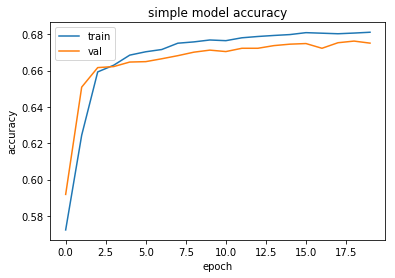

In [36]:
# Highly inspired by
# https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

plt.plot(history_simple.history['acc'])
plt.plot(history_simple.history['val_acc'])
plt.title('simple model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.savefig('./figures/neural_network_history_simple.png')

In [37]:
fc_nn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [38]:
# predict crisp classes for test set
yPred_classes = fc_nn1.predict_classes(X_test, verbose=0)

getValidationMetric(y_test, yPred_classes)

Accuracy:  0.675116
Precision: 0.798370
Recall:    0.691894
F1 score:  0.741328
TN: 1852, FP: 1039, FN: 1832, TP: 4114


### Final neural network

In [39]:
fc_nn = keras.models.Sequential()
fc_nn.add(keras.layers.Dense(13, activation='relu', input_shape=(13,)))
fc_nn.add(keras.layers.Dense(26, activation='relu'))
fc_nn.add(keras.layers.Dropout(0.2))
fc_nn.add(keras.layers.Dense(13, activation='relu'))
fc_nn.add(keras.layers.Dropout(0.2))
fc_nn.add(keras.layers.Dense(1, activation = 'sigmoid'))

fc_nn.compile(optimizer = 'adam', 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy'])

history = fc_nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20, shuffle=True)

Train on 26508 samples, validate on 8837 samples
Epoch 1/20
26508/26508 [==============================] - 3s 108us/step - loss: 0.6289 - acc: 0.6489 - val_loss: 0.5952 - val_acc: 0.6782
Epoch 2/20
26508/26508 [==============================] - 3s 94us/step - loss: 0.5942 - acc: 0.6874 - val_loss: 0.5780 - val_acc: 0.7015
Epoch 3/20
26508/26508 [==============================] - 2s 94us/step - loss: 0.5835 - acc: 0.6951 - val_loss: 0.5723 - val_acc: 0.7040
Epoch 4/20
26508/26508 [==============================] - 3s 101us/step - loss: 0.5784 - acc: 0.6986 - val_loss: 0.5664 - val_acc: 0.7079
Epoch 5/20
26508/26508 [==============================] - 3s 95us/step - loss: 0.5742 - acc: 0.7032 - val_loss: 0.5679 - val_acc: 0.7101
Epoch 6/20
26508/26508 [==============================] - 3s 95us/step - loss: 0.5734 - acc: 0.7001 - val_loss: 0.5637 - val_acc: 0.7106
Epoch 7/20
26508/26508 [==============================] - 2s 93us/step - loss: 0.5714 - acc: 0.6987 - val_loss: 0.5644 - val_ac

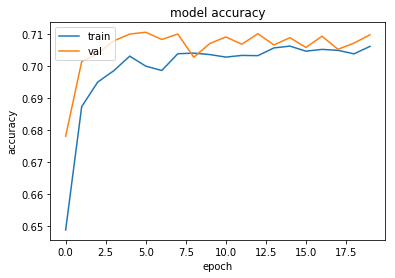

In [40]:
# Highly inspired by
# https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.savefig('./figures/neural_network_history.png')

### Final neural network

In [41]:
fc_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_4 (Dense)              (None, 26)                364       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 13)                351       
_________________________________________________________________
dropout_2 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 14        
Total params: 911
Trainable params: 911
Non-trainable params: 0
_________________________________________________________________


In [42]:
# predict crisp classes for test set
yPred_classes = fc_nn.predict_classes(X_test, verbose=0)


getValidationMetric(y_test, yPred_classes)

Accuracy:  0.709856
Precision: 0.822045
Recall:    0.720041
F1 score:  0.767669
TN: 2037, FP: 917, FN: 1647, TP: 4236
